In [1]:
%load_ext watermark
%watermark -a 'cs224' -u -d -v -p numpy,xarray,scipy,pandas,sklearn,matplotlib,seaborn,pymc3

cs224 
last updated: 2020-03-29 

CPython 3.6.10
IPython 7.13.0

numpy 1.18.1
xarray 0.15.0
scipy 1.4.1
pandas 1.0.2
sklearn 0.22.1
matplotlib 3.1.3
seaborn 0.10.0
pymc3 3.8


In [2]:
%matplotlib inline
import numpy as np, scipy, scipy.stats as stats, scipy.special, scipy.misc, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, xarray as xr
import matplotlib as mpl

import pymc3 as pm

import theano as thno
import theano.tensor as T

import sklearn, sklearn.linear_model

import datetime, time, math
from dateutil import relativedelta

from collections import OrderedDict

SEED = 42
np.random.seed(SEED)

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
# pd.set_option('display.float_format', lambda x: '%.2f' % x)
np.set_printoptions(edgeitems=10)
np.set_printoptions(linewidth=1000)
np.set_printoptions(suppress=True)
np.core.arrayprint._line_width = 180

sns.set()

In [3]:
from IPython.display import display, HTML

from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        if type(df) == np.ndarray:
            df = pd.DataFrame(df)
        html_str+=df.to_html()
    html_str = html_str.replace('table','table style="display:inline"')
    # print(html_str)
    display_html(html_str,raw=True)

CSS = """
.output {
    flex-direction: row;
}
"""

def display_graphs_side_by_side(*args):
    html_str='<table><tr>'
    for g in args:
        html_str += '<td>'
        html_str += g._repr_svg_()
        html_str += '</td>'
    html_str += '</tr></table>'
    display_html(html_str,raw=True)
    

display(HTML("<style>.container { width:70% !important; }</style>"))

In [4]:
%load_ext autoreload
%autoreload 1
%aimport covid19

Data Source: [CSSEGISandData/COVID-19](https://github.com/CSSEGISandData/COVID-19), the data behind the dashboard: [Coronavirus COVID-19 Global Cases by the Center for Systems Science and Engineering (CSSE) at Johns Hopkins University (JHU)](https://gisanddata.maps.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6).

It seems that there are currently [data-changes](https://github.com/CSSEGISandData/COVID-19/commit/0cea9b2179306618bd7917798819ebf6608d67de#comments) in progress that cause issues. This is mostly an issue for the US data, so that I comment it out. The US data as used in this notebook **is currently wrong**.

In [5]:
covid19.time_series_19_covid_confirmed.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,4,4,5,7,7,7,11,16,21,22,22,22,24,24,40,40,74,84,94,110,110
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,10,12,23,33,38,42,51,55,59,64,70,76,89,104,123,146,174,186,197
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,3,5,12,12,17,17,19,20,20,20,24,26,37,48,54,60,74,87,90,139,201,230,264,302,367,409,454
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,39,39,53,75,88,113,133,164,188,224,267,308
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,3,3,3,4,4,5


In [6]:
covid19.time_series_19_covid_recovered.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,2,2,2,2
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,10,17,17,31,31
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,8,12,12,12,12,12,32,32,32,65,65,24,65,29,29,31
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [7]:
list(covid19.augment_time_series_from_daily_snapshots_date_range)

[]

In [8]:
# ldf = covid19.augment_time_series_from_daily_snapshots(covid19.augment_time_series_from_daily_snapshots_date_range)
# ldf

In [9]:
# ldf = covid19.augment_time_series_from_daily_snapshots(covid19.augment_time_series_from_daily_snapshots_date_range)[0][['Province/State', 'Country/Region', '3/15/20']]
# # # ldf[ldf['3/14/20'] < 0]
# ldf[ldf['Country/Region'] == 'Spain']

In [10]:
# ldf_confirmed, ldf_recovered, ldf_death, columns, selector = covid19.get_cases_by_region()

In [11]:
df = covid19.get_cases_by_region()
df.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-03-24,32991,3290,159,3935,2837,36
2020-03-25,37323,3547,206,4332,257,47
2020-03-26,43211,5678,262,5888,2131,56
2020-03-27,49039,6932,323,5828,1254,61
2020-03-28,54268,8481,398,5229,1549,75


In [12]:
df = covid19.get_cases_by_region(region='China')
df.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-03-24,81591,73280,3281,93,466,7
2020-03-25,81661,73773,3285,70,493,4
2020-03-26,81782,74181,3291,121,408,6
2020-03-27,81897,74720,3296,115,539,5
2020-03-28,81999,75100,3299,102,380,3


In [13]:
# df = covid19.get_cases_by_region(region='Switzerland')
# df

In [14]:
# df = covid19.get_cases_by_region(region='US')
# df

* [BAR CHART ANNOTATIONS WITH PANDAS AND MATPLOTLIB](https://robertmitchellv.com/blog-bar-chart-annotations-pandas-mpl.html)

In [15]:
cbr_germany = covid19.CasesByRegion('Germany')
cbr_germany.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-03-24,32991,3290,159,3935,2837,36
2020-03-25,37323,3547,206,4332,257,47
2020-03-26,43211,5678,262,5888,2131,56
2020-03-27,49039,6932,323,5828,1254,61
2020-03-28,54268,8481,398,5229,1549,75


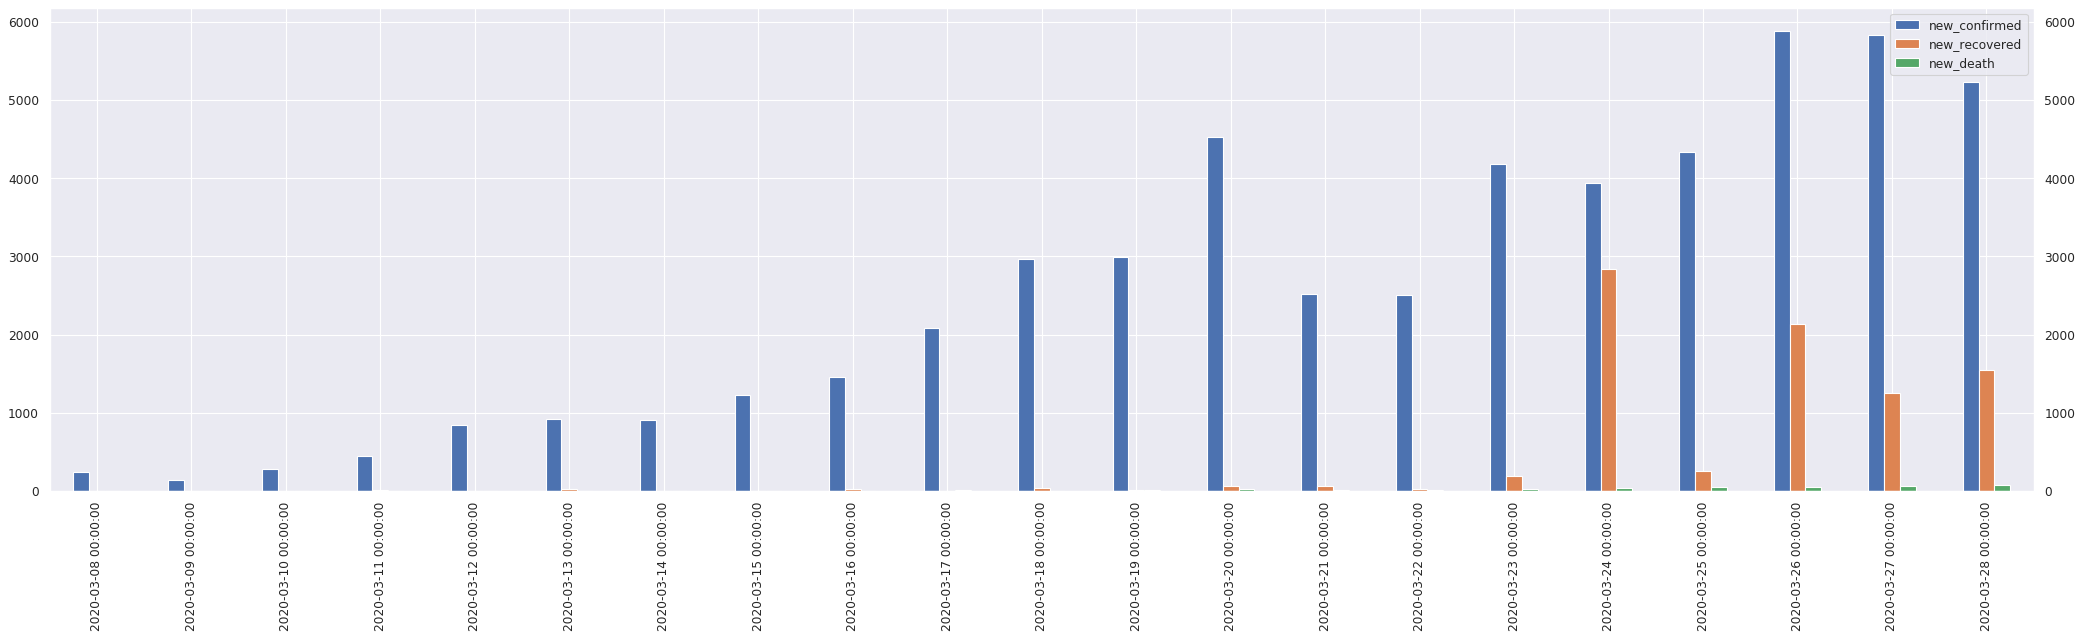

In [16]:
cbr_germany.plot_daily_stats()

135.0 184.0


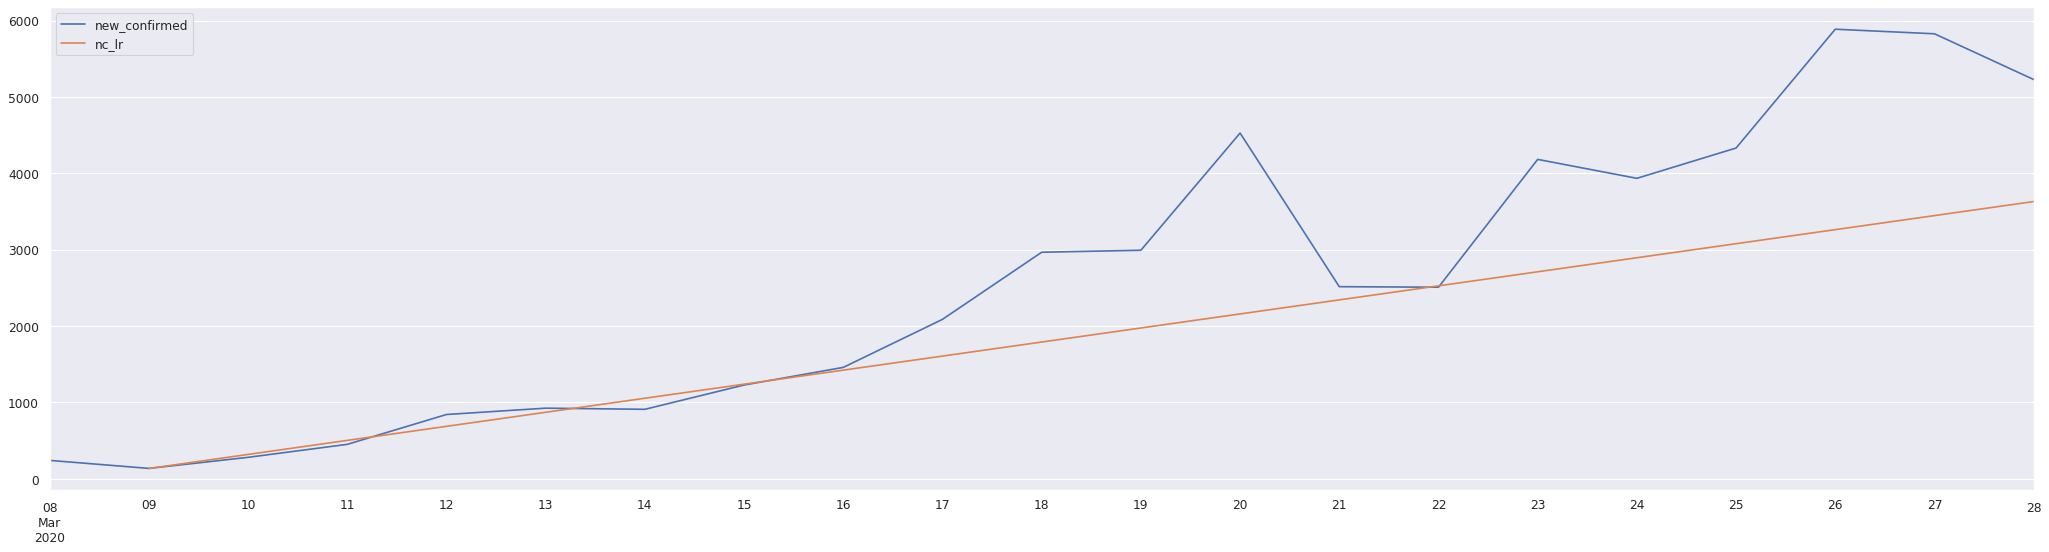

In [17]:
date_range = pd.date_range(pd.to_datetime('2020-03-09'),pd.to_datetime('2020-03-16'))
cbr_germany_new_confirmed_df = cbr_germany.df.loc[date_range,['new_confirmed']]
x = np.arange(len(cbr_germany_new_confirmed_df) * 1.0)

regressor = sklearn.linear_model.LinearRegression()  
regressor.fit(x.reshape(-1, 1), cbr_germany_new_confirmed_df.new_confirmed.values.reshape(-1, 1) * 1.0)

last_day = cbr_germany.df.index[-1]
ldr = pd.date_range(pd.to_datetime('2020-03-09'),pd.to_datetime(last_day))
x = np.arange(len(ldr) * 1.0)

y = regressor.intercept_[0] + regressor.coef_[0,0]*x
cbr_germany_new_confirmed_lr_df = pd.DataFrame(y.reshape(-1,1),index=ldr, columns=['nc_lr'])

ldf = pd.concat([cbr_germany.df, cbr_germany_new_confirmed_lr_df], axis=1)
ldf.loc[:] = ldf.values * 1.0
ldf = ldf.loc[last_day + datetime.timedelta(days=-20):,['new_confirmed', 'nc_lr']]
fig = plt.figure(figsize=(32, 8), dpi=80, facecolor='w', edgecolor='k')
ax  = plt.subplot(1, 1, 1)
ldf.plot(ax=ax)
print(regressor.intercept_[0].round(2), regressor.coef_[0,0].round(2))

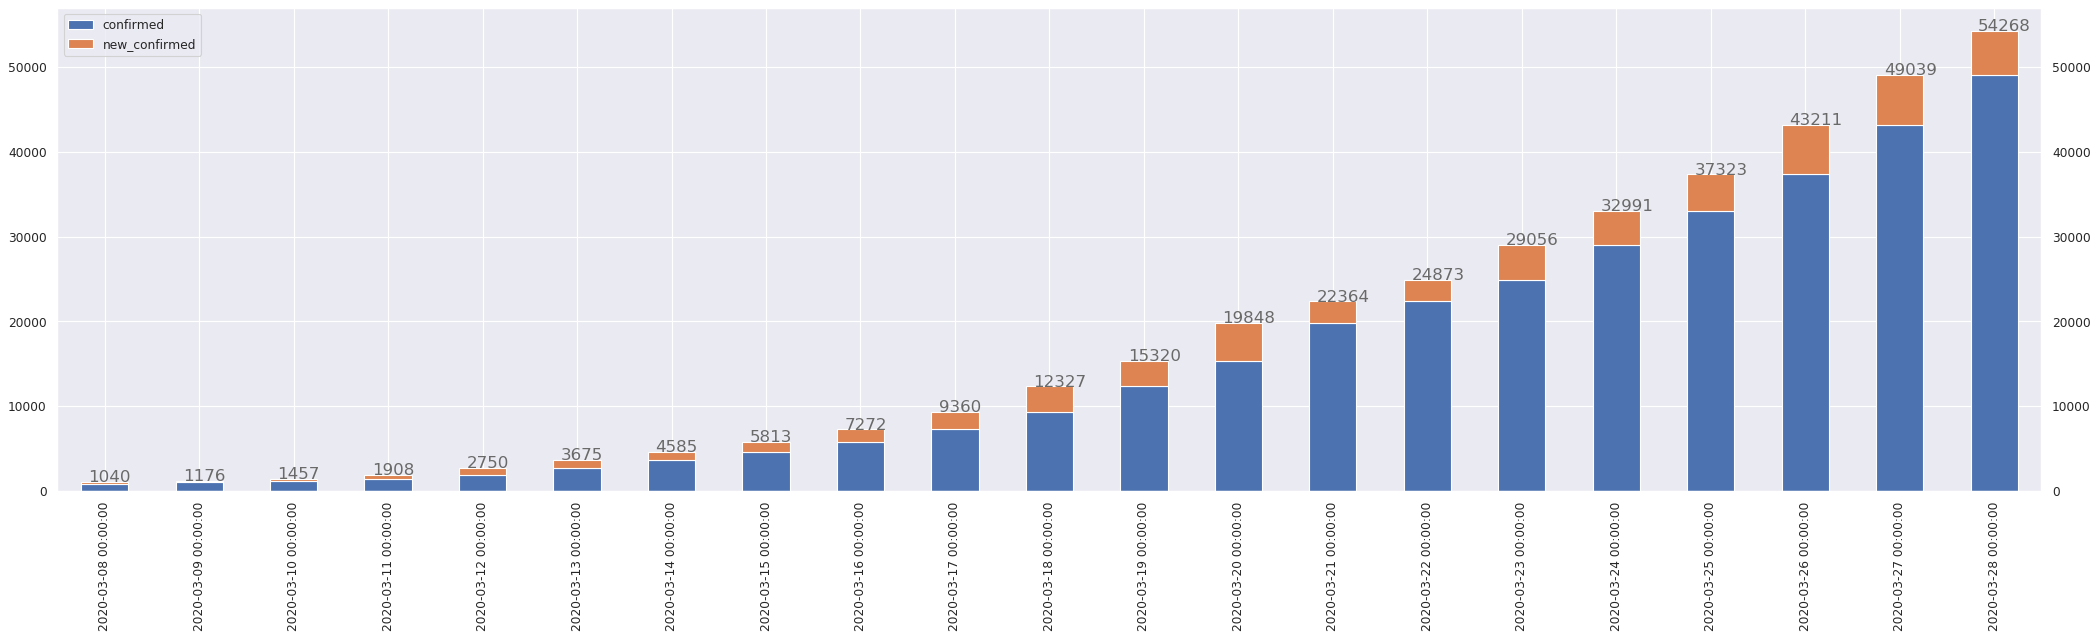

In [18]:
cbr_germany.plot_daily_stacked()

In [19]:
cbr_austria = covid19.CasesByRegion('Austria')
cbr_austria.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-03-24,5283,9,28,809,0,7
2020-03-25,6001,9,42,718,0,14
2020-03-26,6909,112,49,908,103,7
2020-03-27,7657,225,58,748,113,9
2020-03-28,8188,225,68,531,0,10


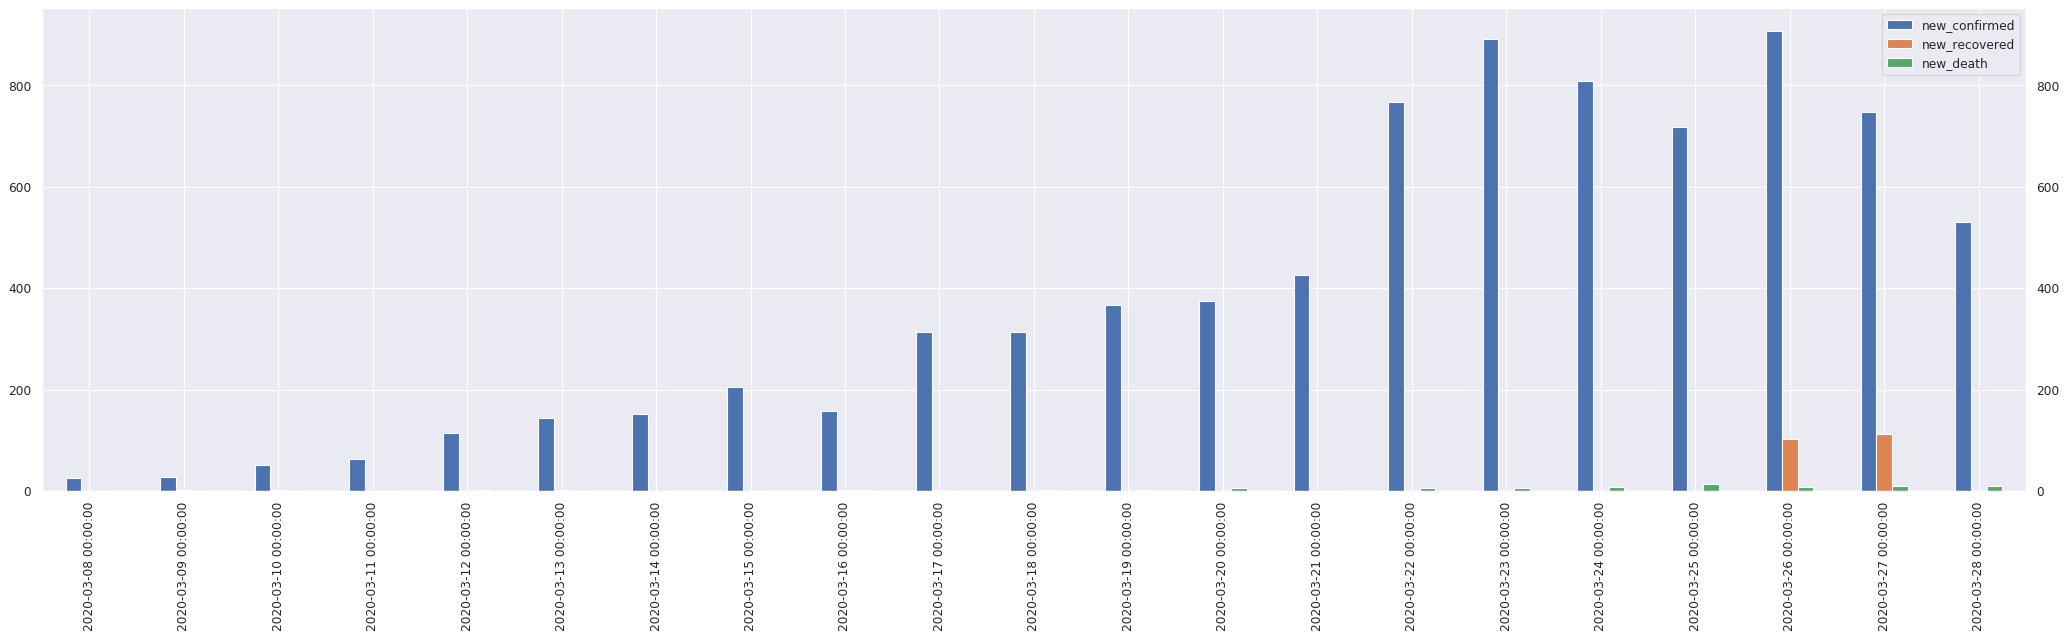

In [20]:
cbr_austria.plot_daily_stats()

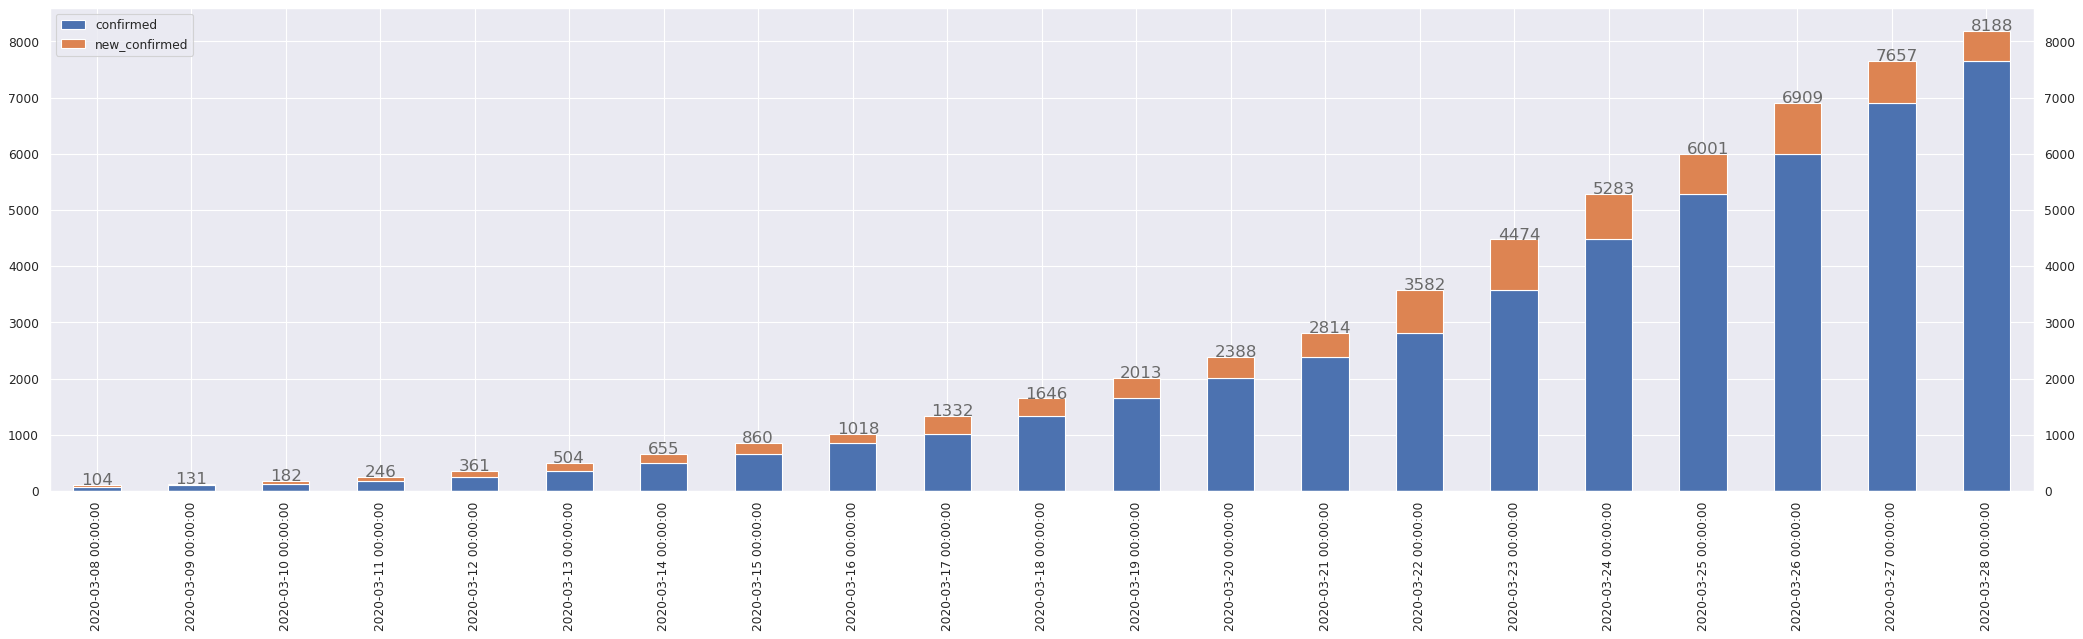

In [21]:
cbr_austria.plot_daily_stacked()

There are several data issues since 2020-03-12/2020-03-13 in the input data as pointed out here: [Italy has the same number of cases today as they did yesterday.](https://github.com/CSSEGISandData/COVID-19/issues/599)

Also trying to get the raw numbers that [Coronavirus-Monitor](https://interaktiv.morgenpost.de/corona-virus-karte-infektionen-deutschland-weltweit/?fbclid=IwAR04HlqzakGaNssQzbz4d8o8R3gz0C910U8tvfYlBT6P0lVJJvHfk9uS2rc) is using for Germany from [@datentaeterin](https://twitter.com/datentaeterin/status/1237807179815686144). These numbers seem to be more up-to-date than all the other data-sources.

In [22]:
fname = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv'
alternative_italy_data = pd.read_csv(fname)
dates = pd.to_datetime(alternative_italy_data['data']).dt.date
alternative_italy_data = alternative_italy_data.rename(columns={"totale_casi": "confirmed", "deceduti": "death", "dimessi_guariti": "recovered"})
alternative_italy_data = alternative_italy_data[['confirmed', 'recovered', 'death']].copy()
for property in ['confirmed', 'recovered', 'death']:
    diff = alternative_italy_data[property].values[1:] - alternative_italy_data[property].values[:-1]
    alternative_italy_data['new_' + property] = np.concatenate([np.array([0]), diff])  
alternative_italy_data.index = dates
alternative_italy_data.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
data,,,,,,
2020-03-24,69176,8326,6820,5249,894,743
2020-03-25,74386,9362,7503,5210,1036,683
2020-03-26,80539,10361,8165,6153,999,662
2020-03-27,86498,10950,9134,5959,589,969
2020-03-28,92472,12384,10023,5974,1434,889


In [23]:
cbr_italy = covid19.CasesByRegion('Italy', df=alternative_italy_data)
cbr_italy.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
data,,,,,,
2020-03-24,69176,8326,6820,5249,894,743
2020-03-25,74386,9362,7503,5210,1036,683
2020-03-26,80539,10361,8165,6153,999,662
2020-03-27,86498,10950,9134,5959,589,969
2020-03-28,92472,12384,10023,5974,1434,889


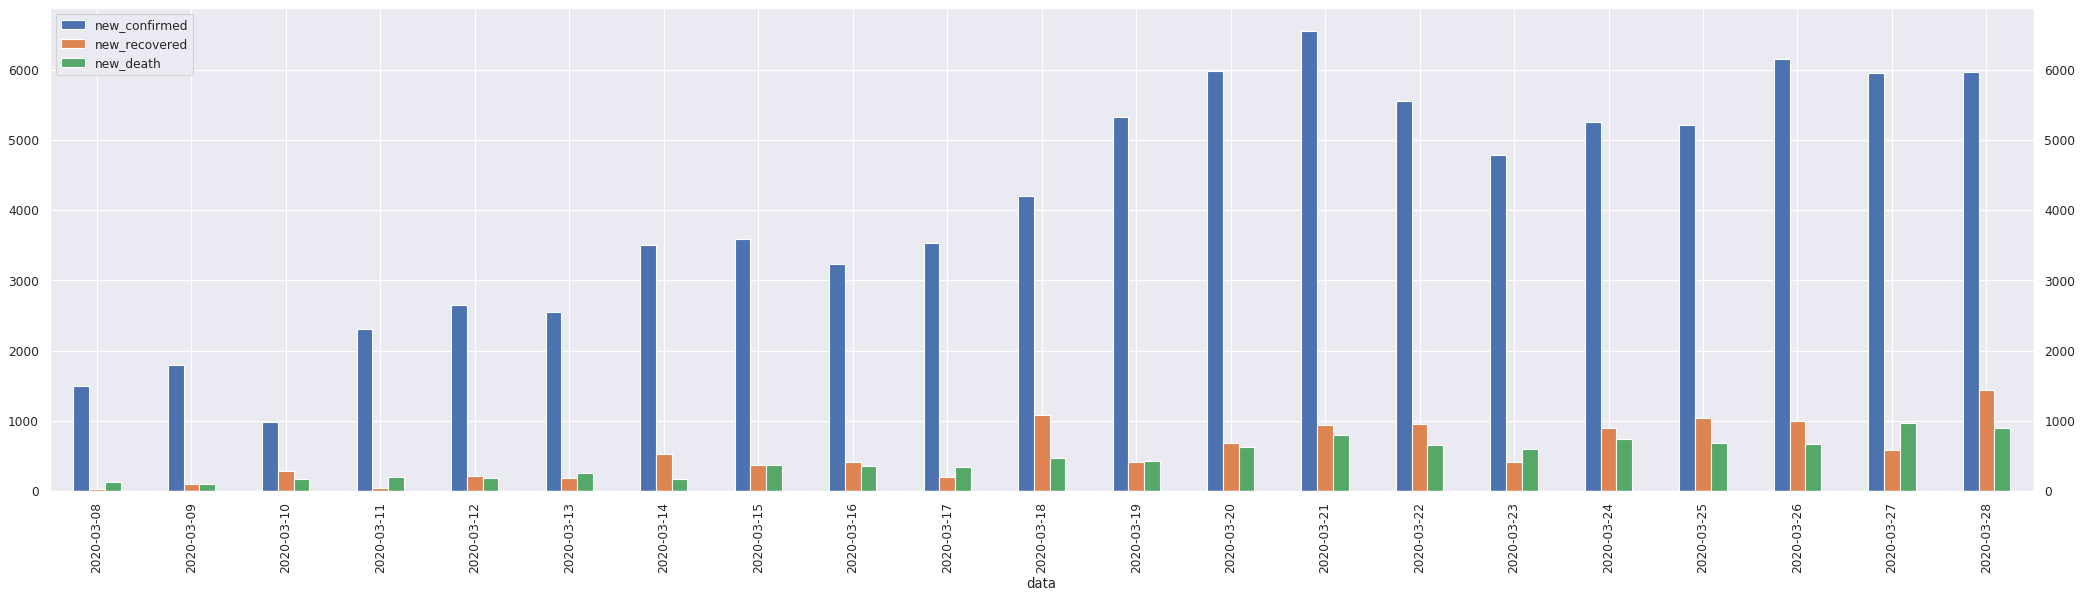

In [24]:
cbr_italy.plot_daily_stats()

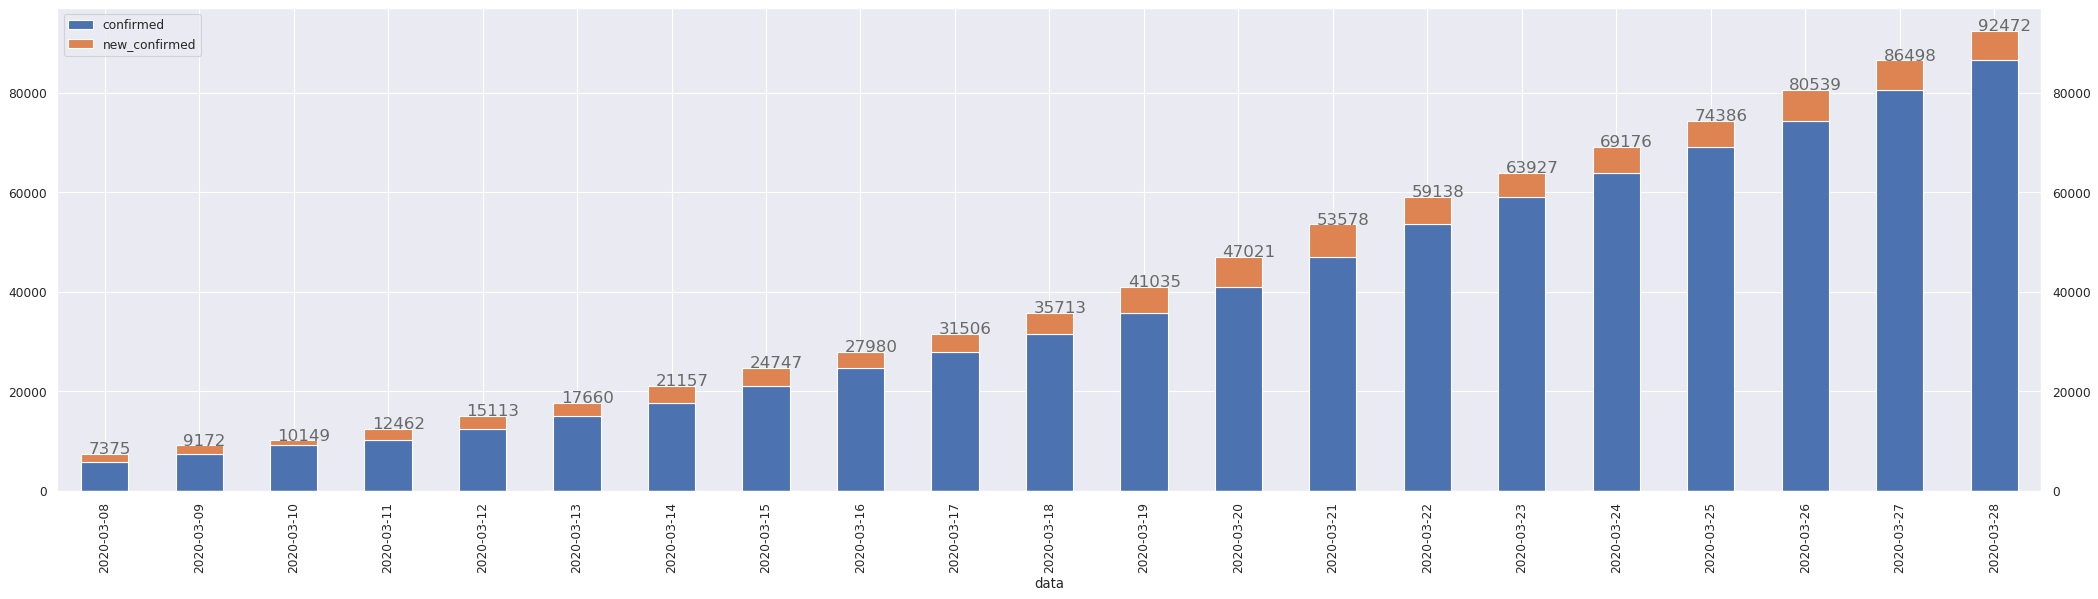

In [25]:
cbr_italy.plot_daily_stacked()

In [26]:
cbr_france = covid19.CasesByRegion('France')
cbr_france.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-03-24,22633,3288,1102,2510,1081,240
2020-03-25,25600,3907,1333,2967,619,231
2020-03-26,29566,4955,1698,3966,1048,365
2020-03-27,33402,5707,1997,3836,752,299
2020-03-28,38105,5724,2317,4703,17,320


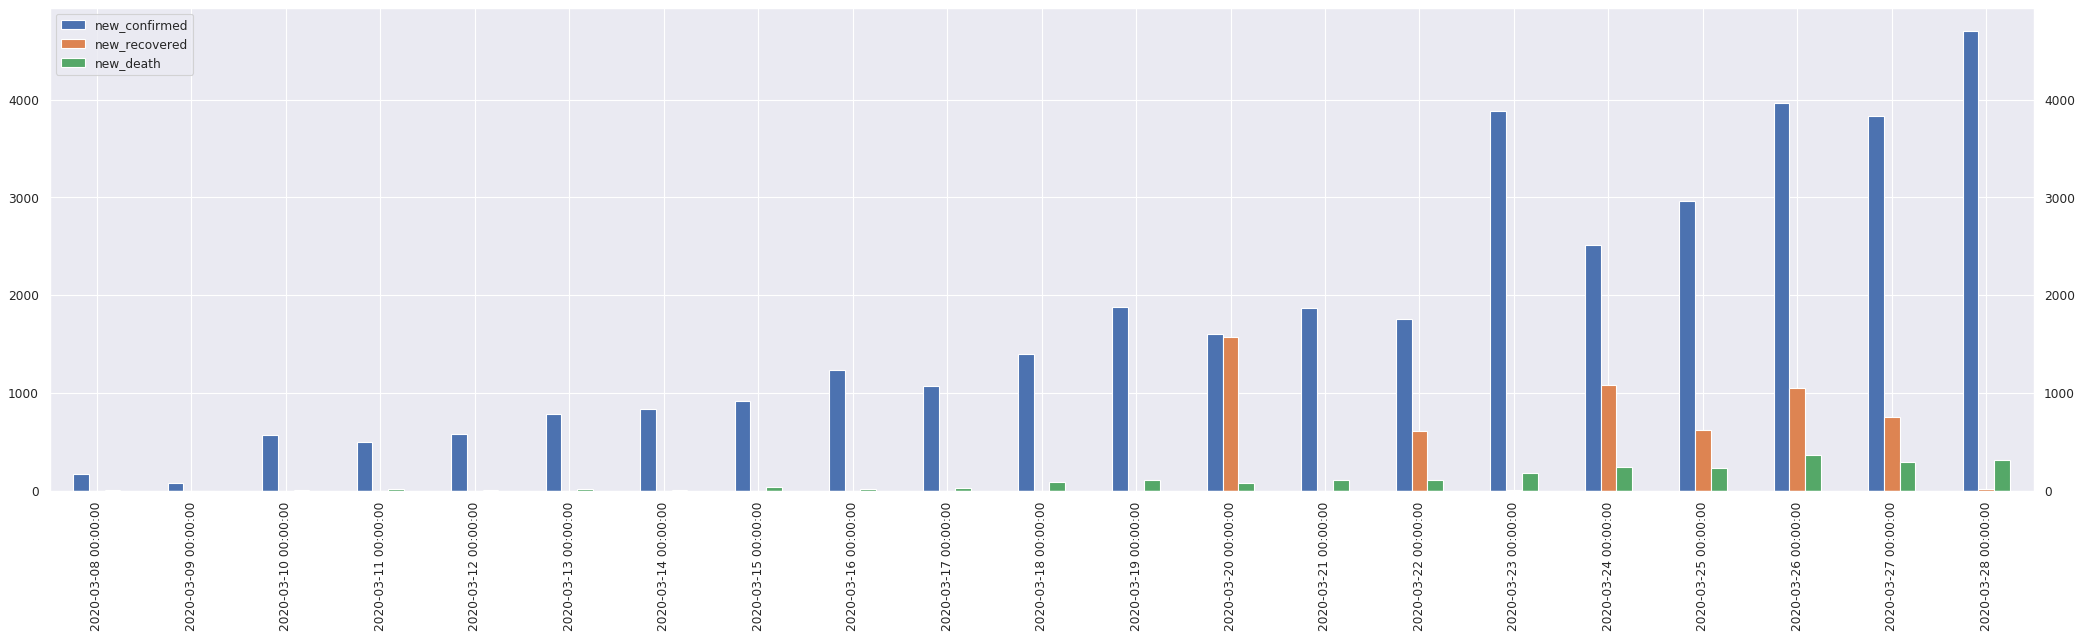

In [27]:
cbr_france.plot_daily_stats()

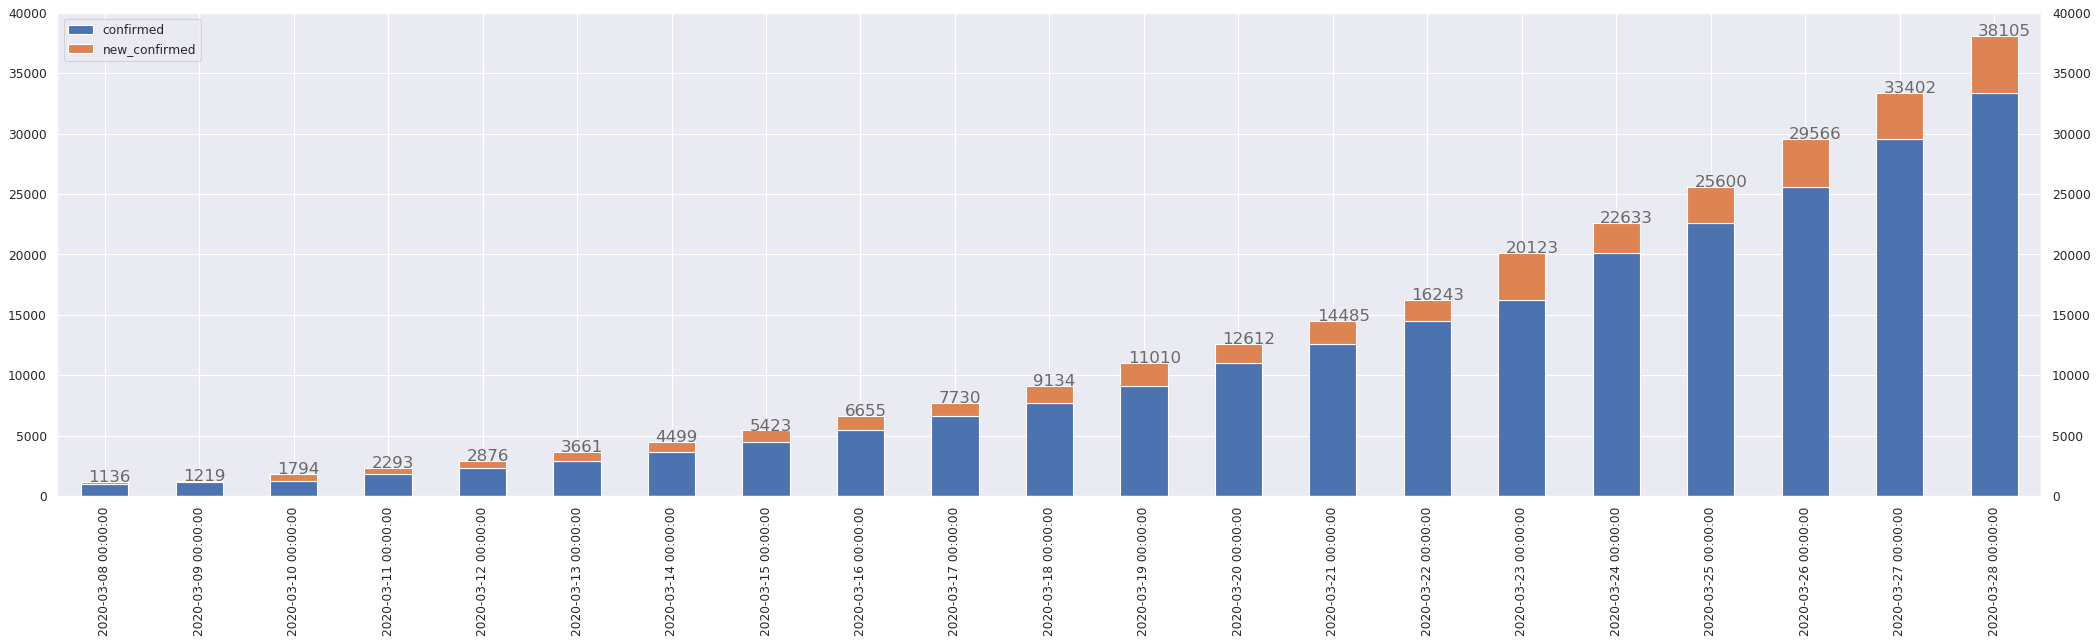

In [28]:
cbr_france.plot_daily_stacked()

In [29]:
cbr_spain = covid19.CasesByRegion('Spain')
cbr_spain.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-03-24,42058,3794,2991,6922,439,680
2020-03-25,49515,5367,3647,7457,1573,656
2020-03-26,57786,7015,4365,8271,1648,718
2020-03-27,65719,9357,5138,7933,2342,773
2020-03-28,73235,12285,5982,7516,2928,844


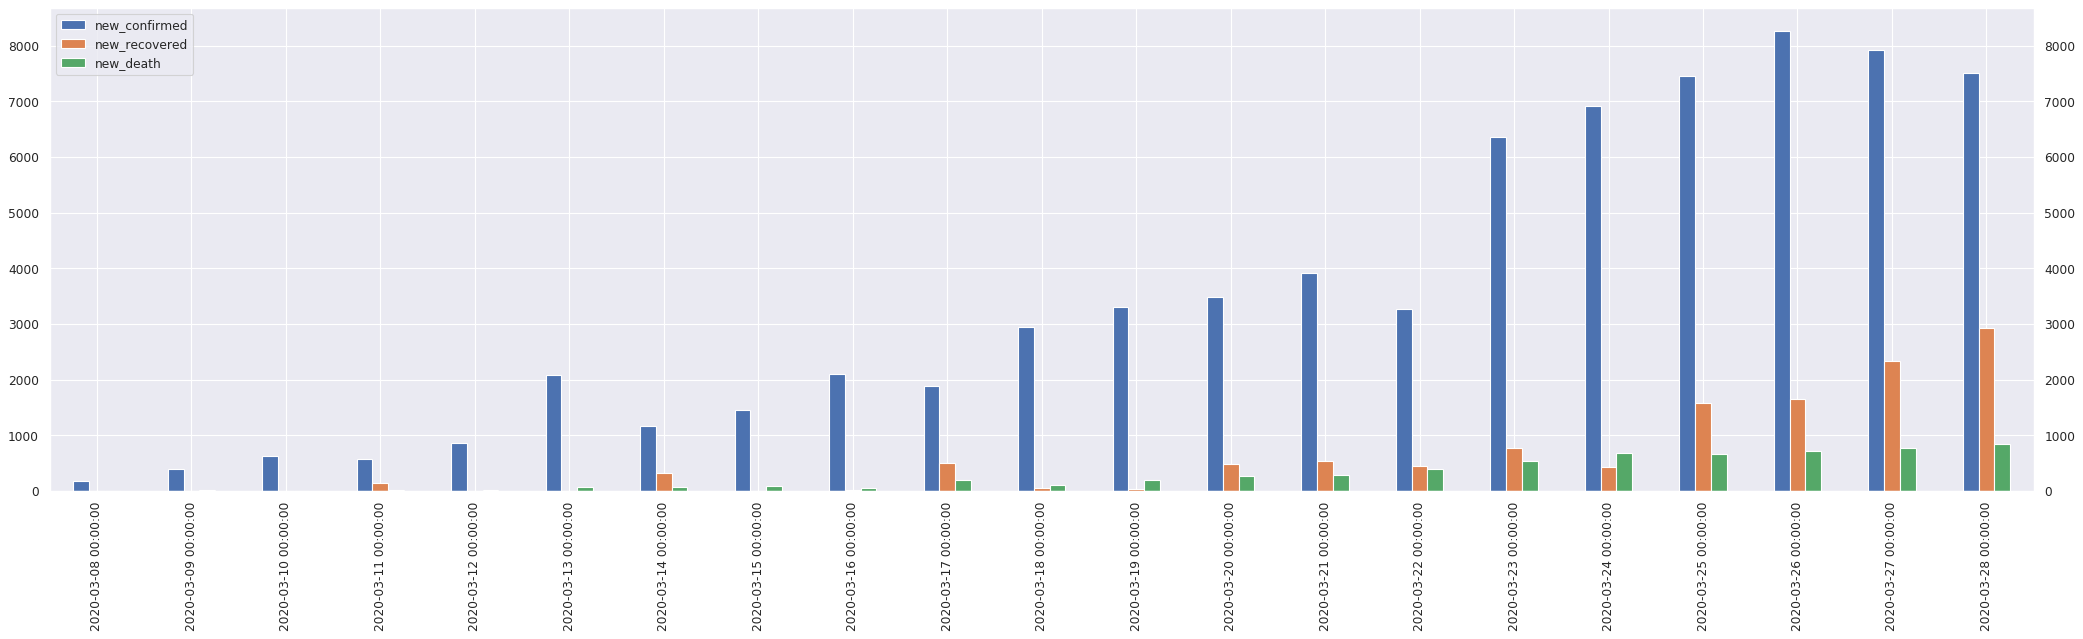

In [30]:
cbr_spain.plot_daily_stats()

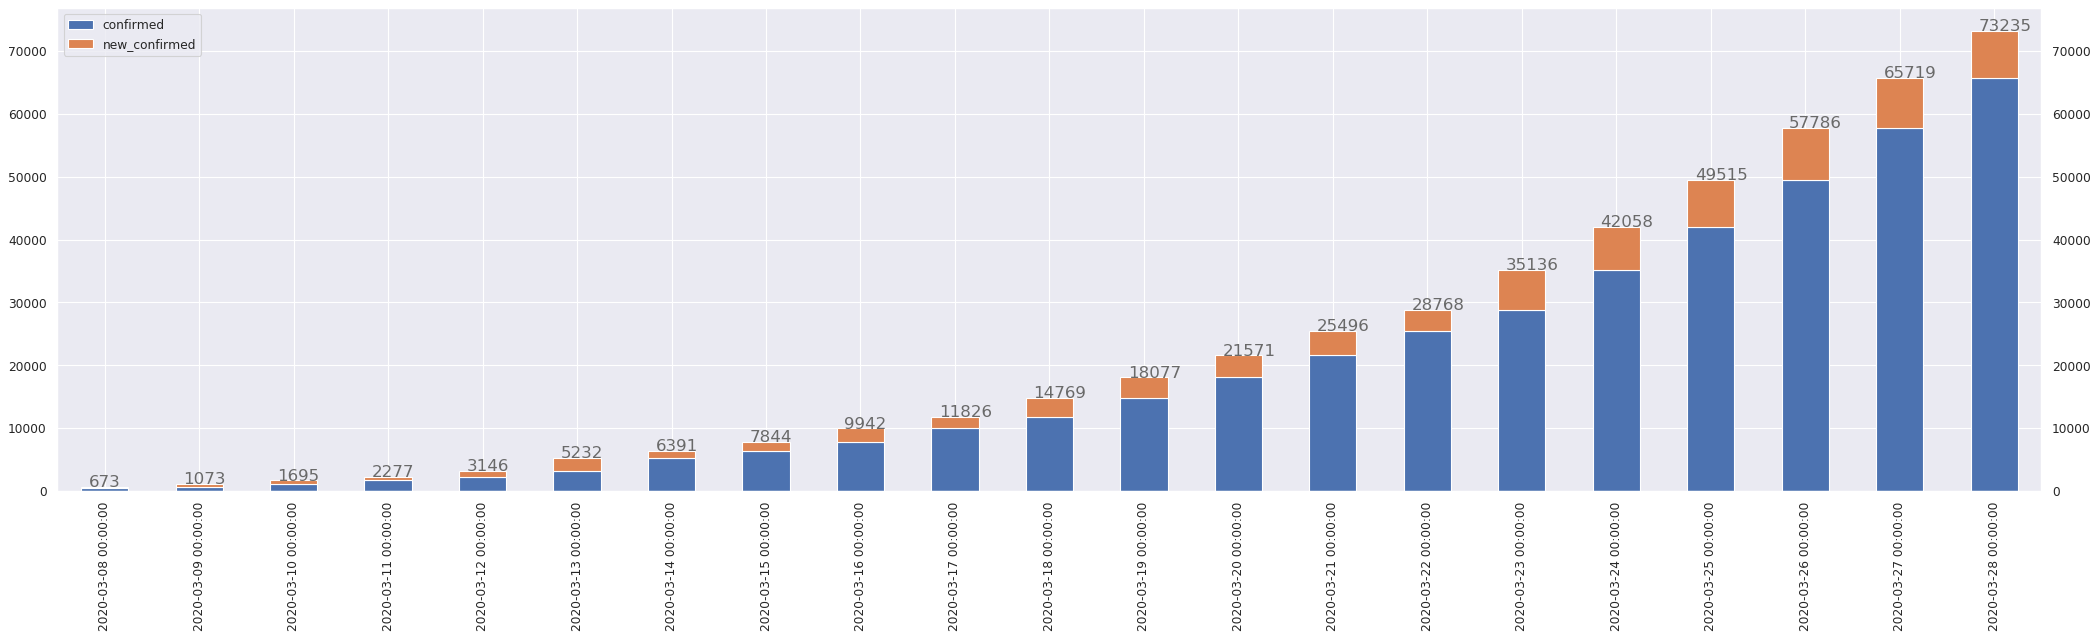

In [31]:
cbr_spain.plot_daily_stacked()

In [32]:
cbr_south_korea = covid19.CasesByRegion('Korea, South')
cbr_south_korea.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-03-24,9037,3507,124,0,0,4
2020-03-25,9241,4144,131,204,637,7
2020-03-26,9241,4144,131,0,0,0
2020-03-27,9332,4528,139,91,384,8
2020-03-28,9478,4811,144,146,283,5


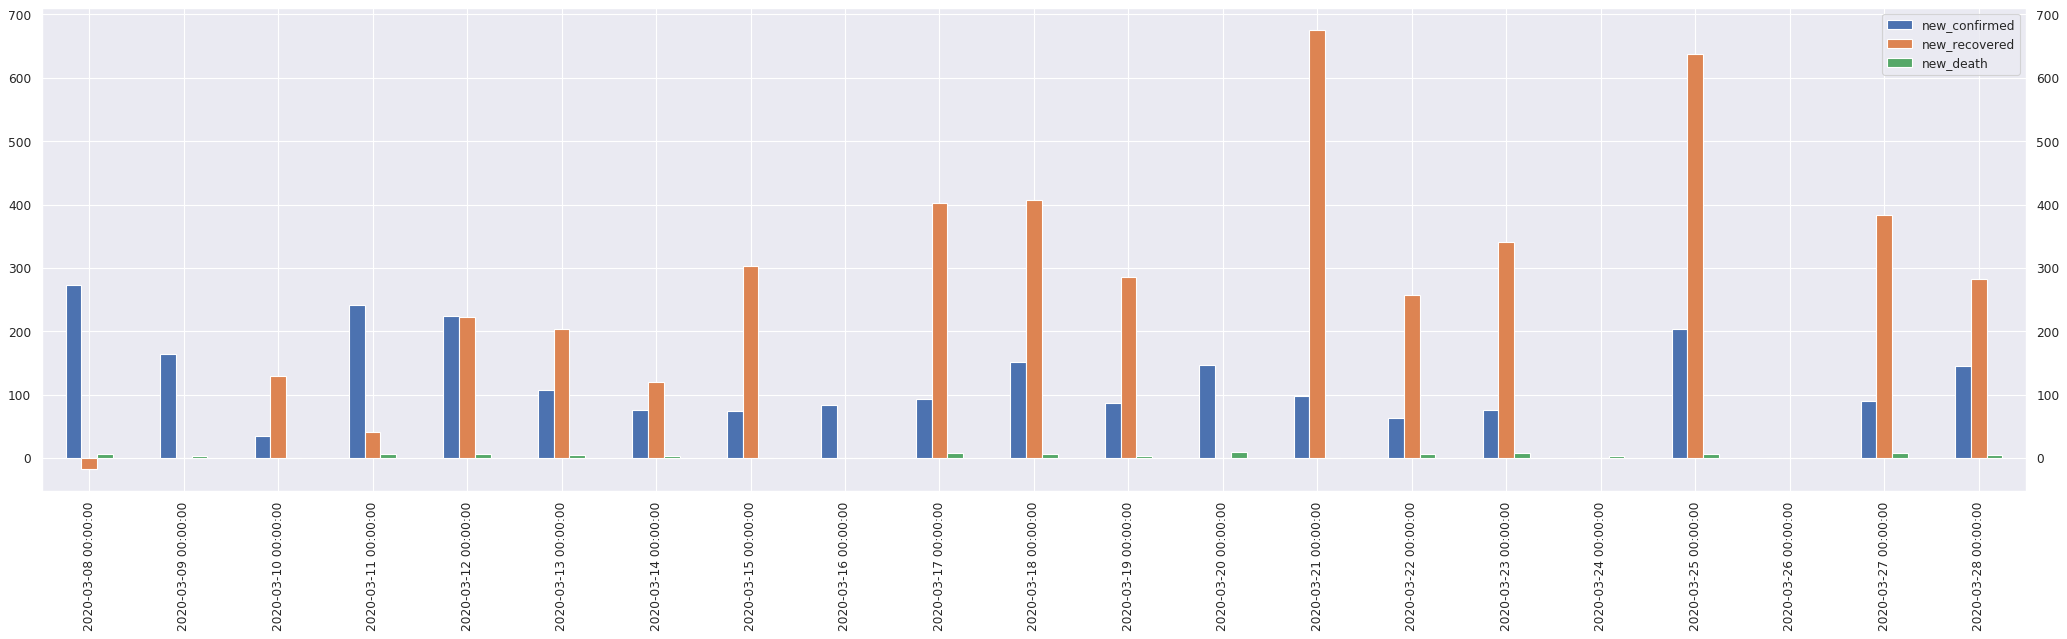

In [33]:
cbr_south_korea.plot_daily_stats()

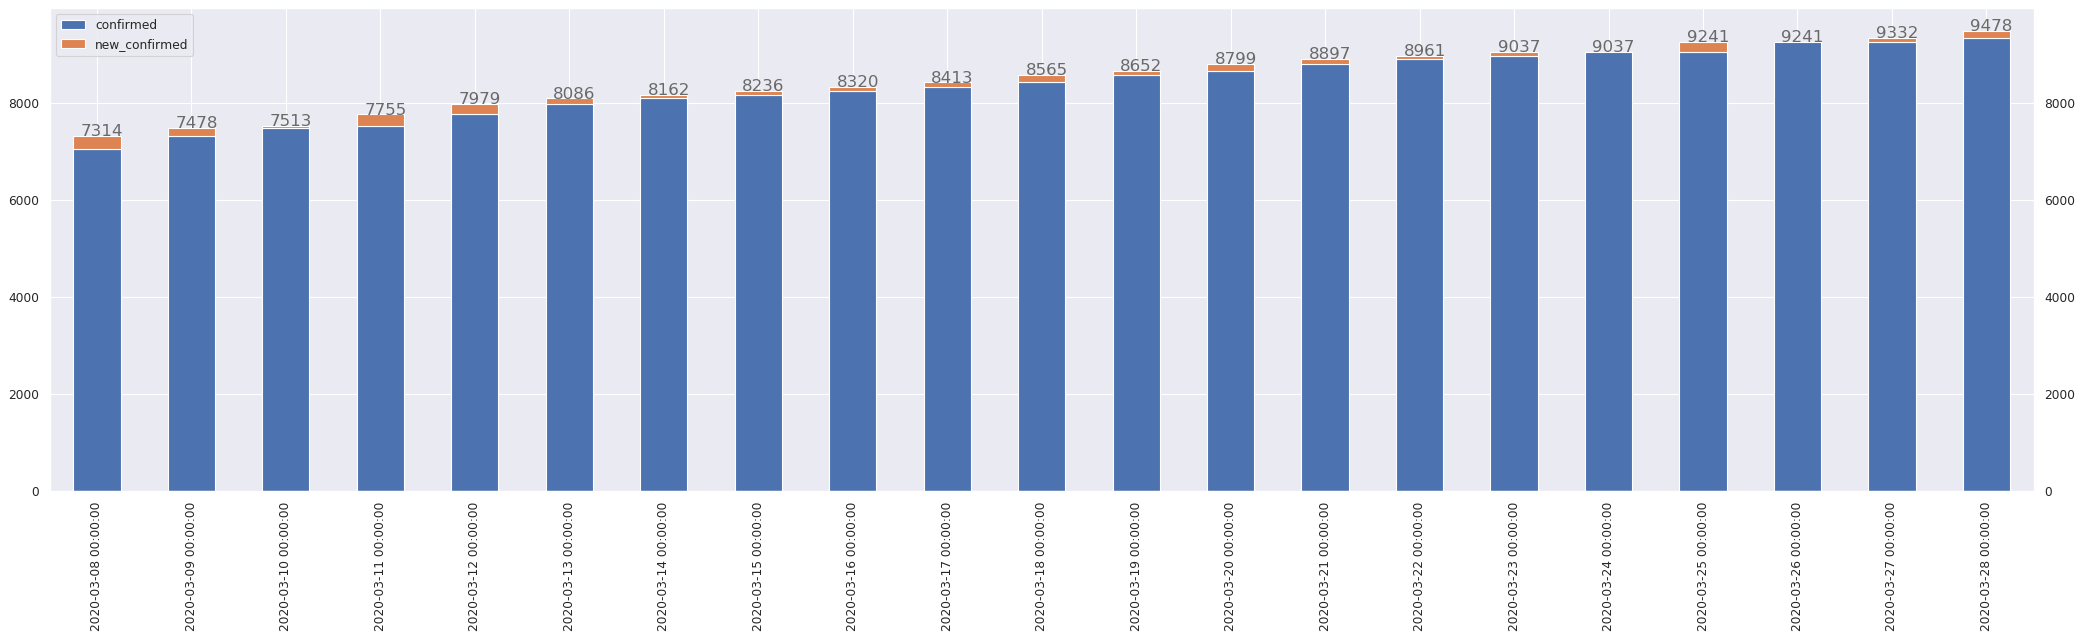

In [34]:
cbr_south_korea.plot_daily_stacked()

In [35]:
cbr_uk = covid19.CasesByRegion('United Kingdom')
cbr_uk.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-03-24,8164,140,423,1438,0,87
2020-03-25,9640,140,467,1476,0,44
2020-03-26,11812,150,580,2172,10,113
2020-03-27,14745,151,761,2933,1,181
2020-03-28,17312,151,1021,2567,0,260


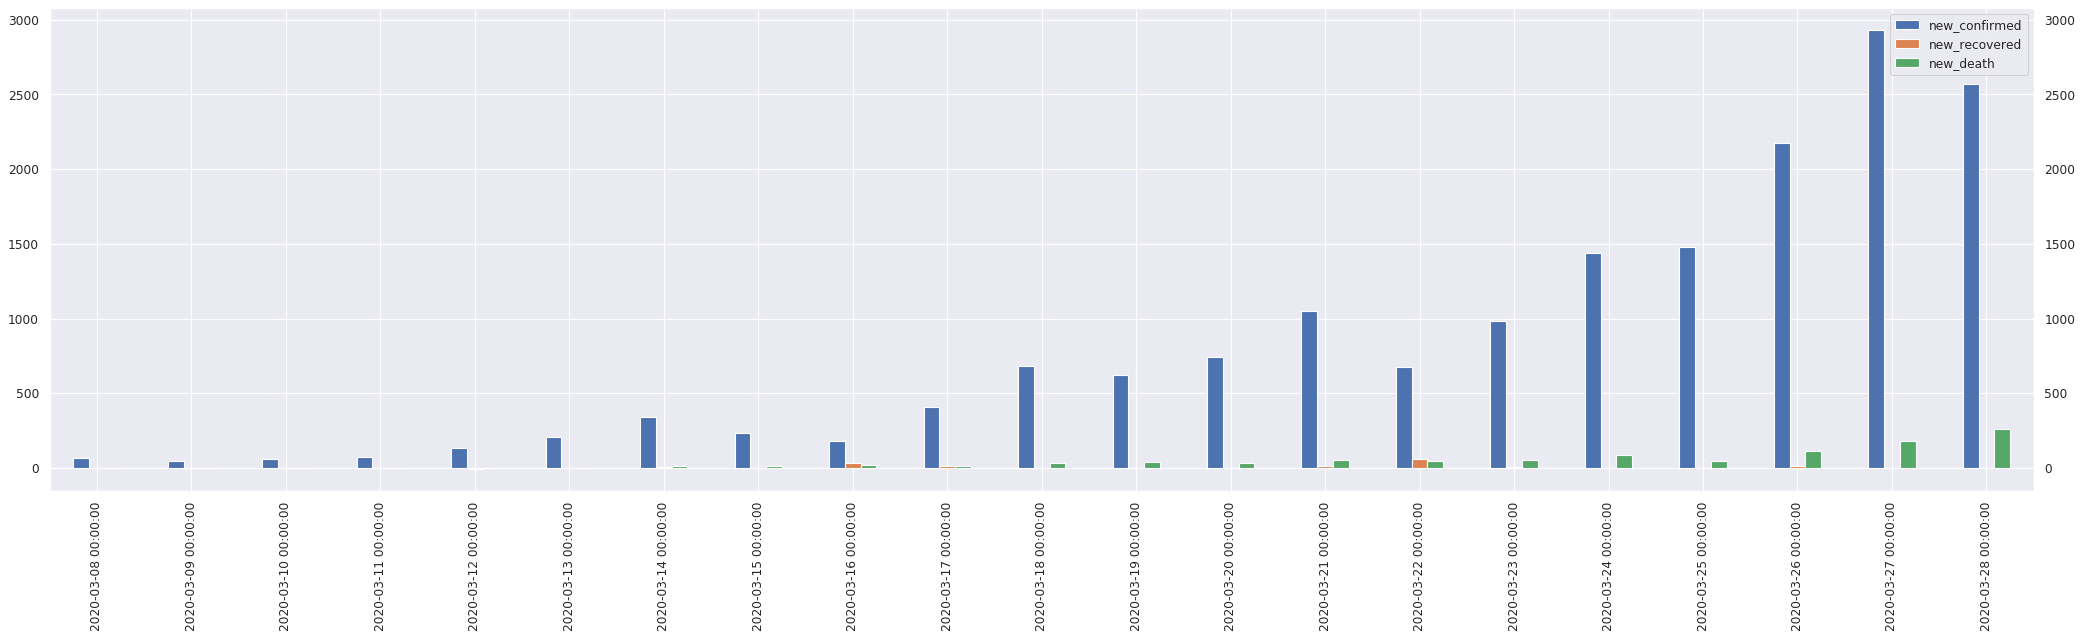

In [36]:
cbr_uk.plot_daily_stats()

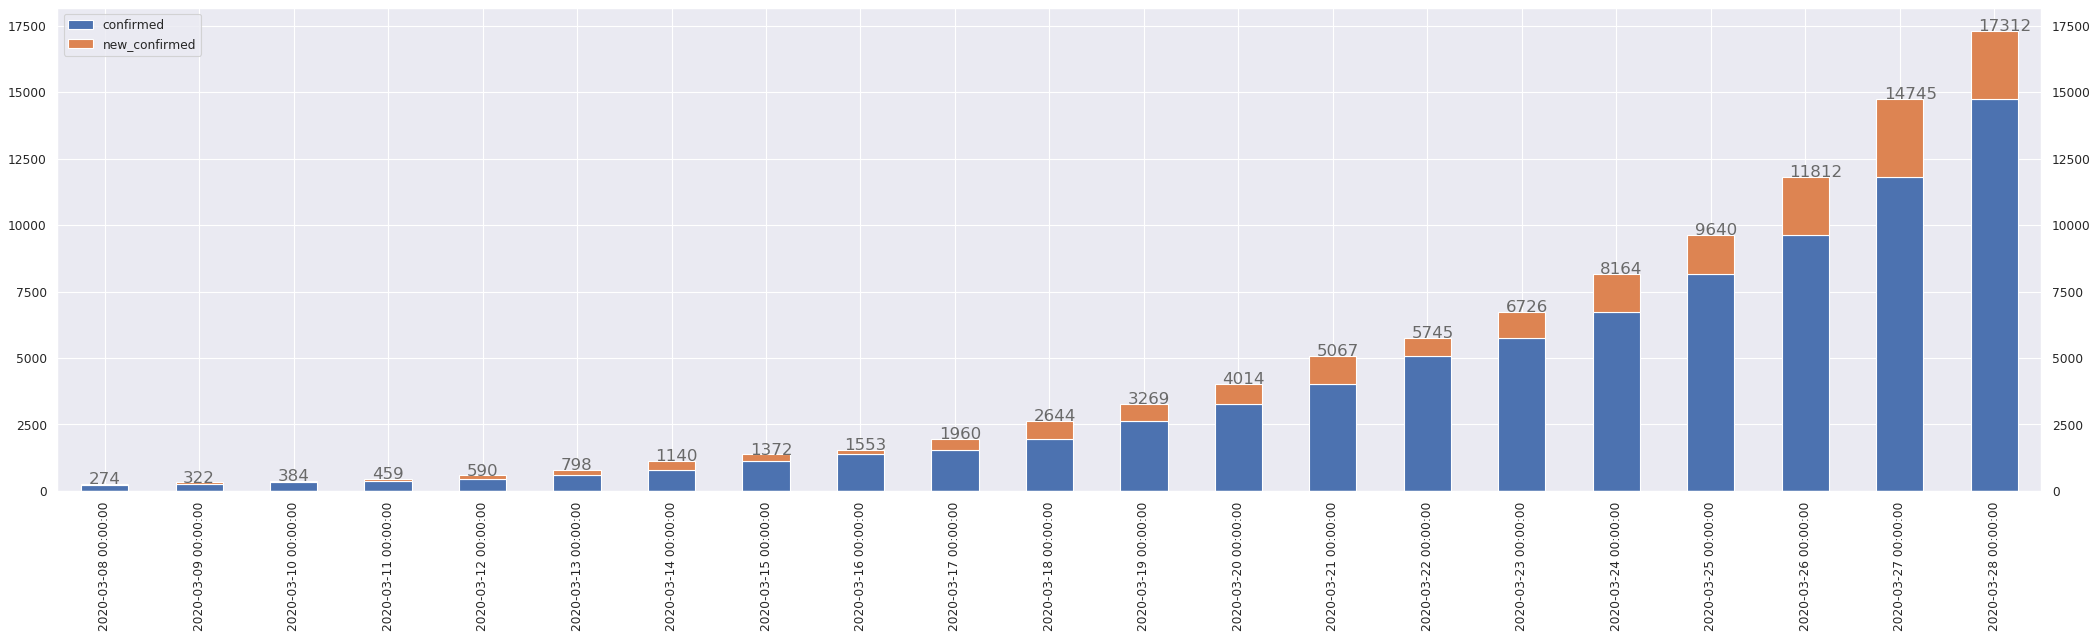

In [37]:
cbr_uk.plot_daily_stacked()

In [38]:
cbr_us = covid19.CasesByRegion('US')
cbr_us.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-03-24,55041,348,790,8709,172,180
2020-03-25,69197,619,1050,14156,271,260
2020-03-26,85991,753,1296,16794,134,246
2020-03-27,101657,869,1581,15666,116,285
2020-03-28,121478,1072,2026,19821,203,445


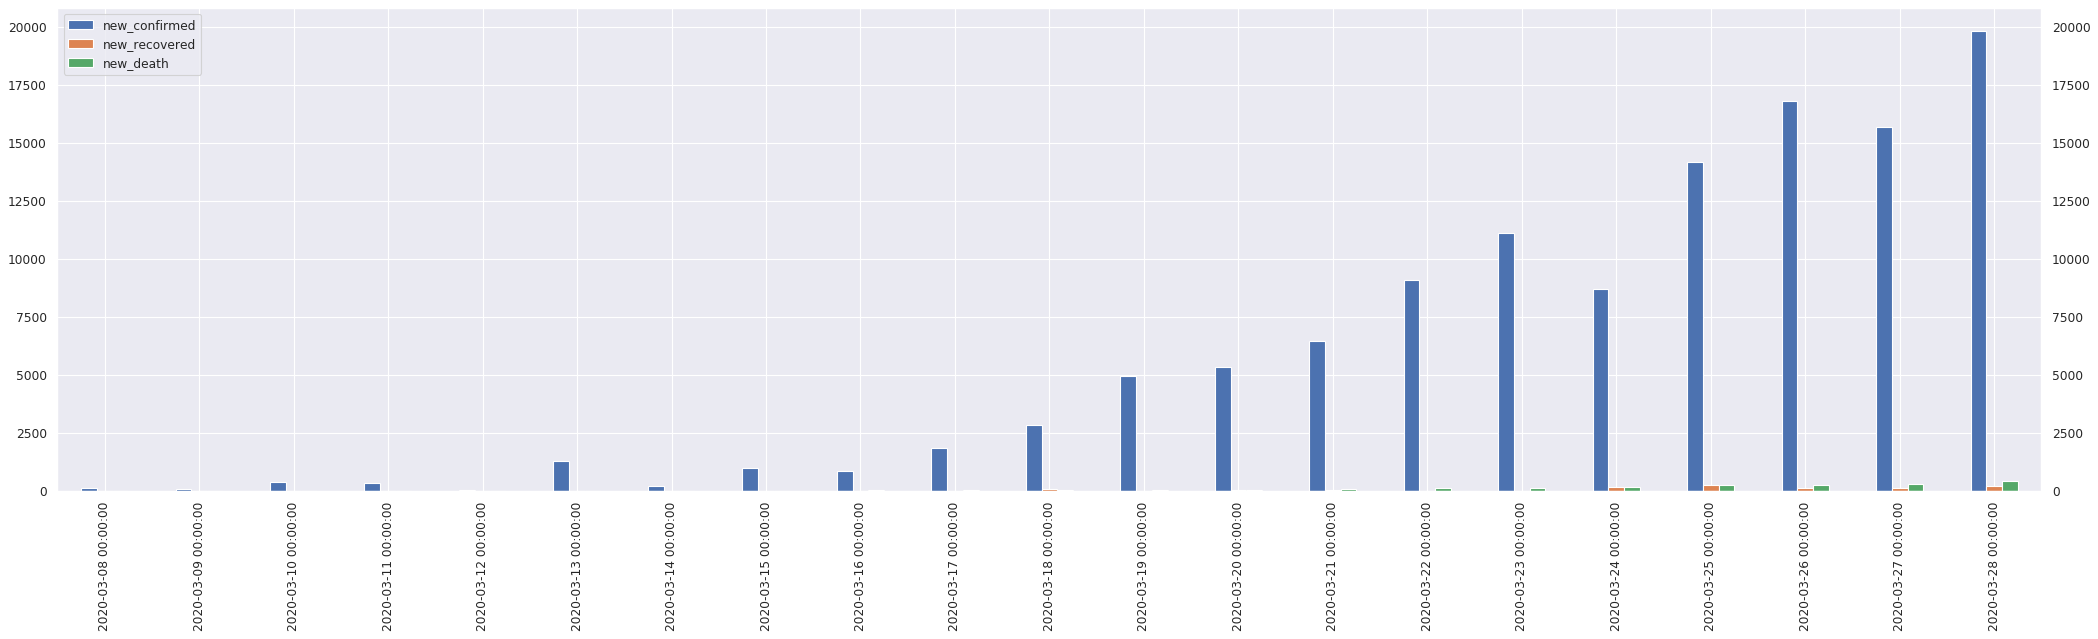

In [39]:
cbr_us.plot_daily_stats()

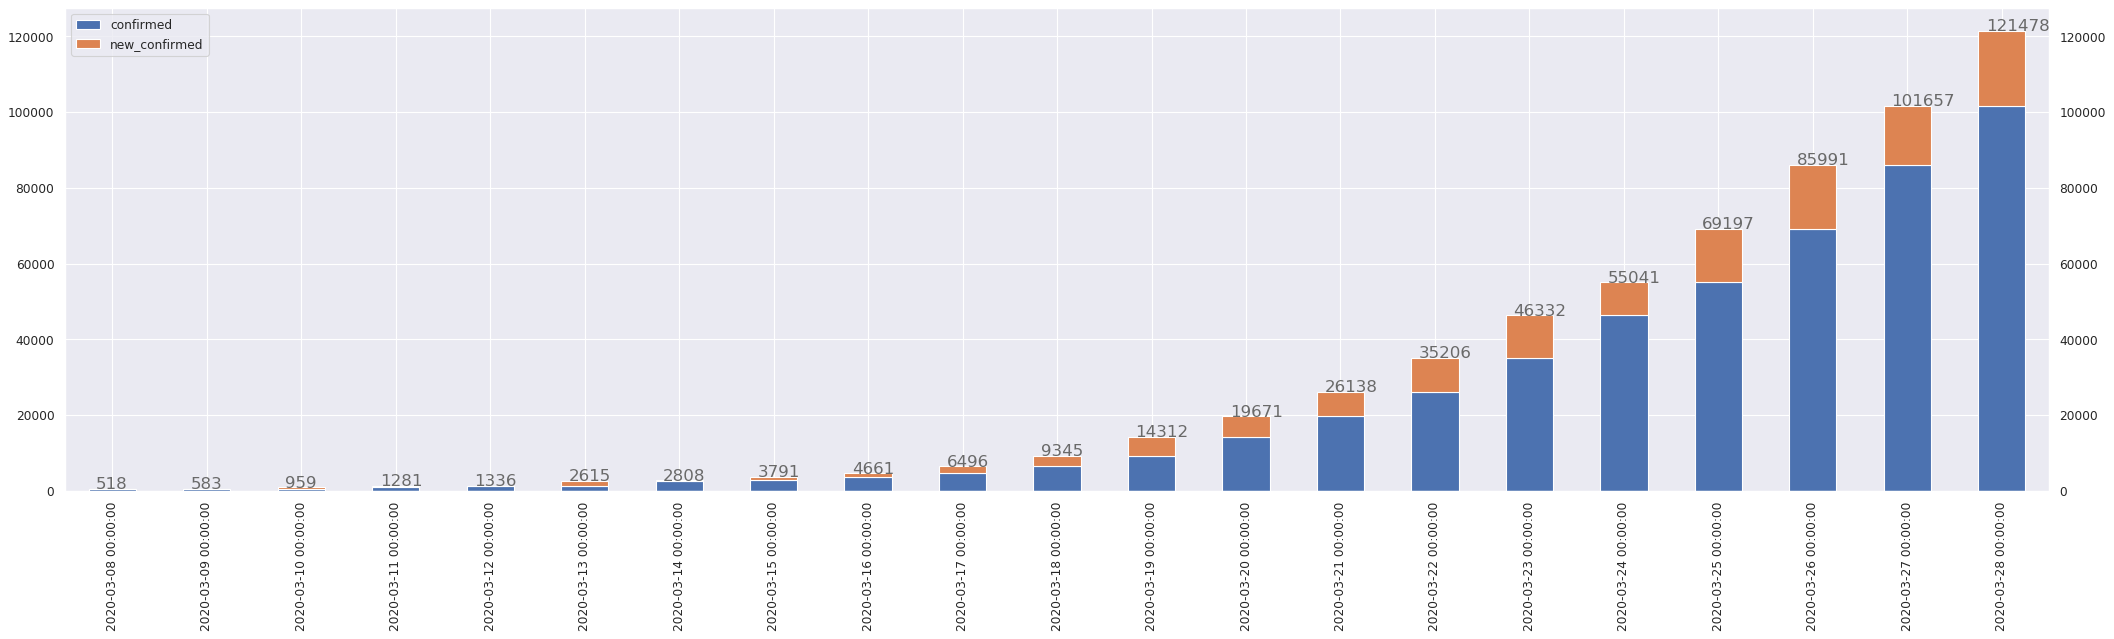

In [40]:
cbr_us.plot_daily_stacked()

In [41]:
cbr_switzerland = covid19.CasesByRegion('Switzerland')
cbr_switzerland.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-03-24,9877,131,130,1082,0,10
2020-03-25,10897,131,153,1020,0,23
2020-03-26,11811,131,192,914,0,39
2020-03-27,12928,1530,231,1117,1399,39
2020-03-28,14076,1530,264,1148,0,33


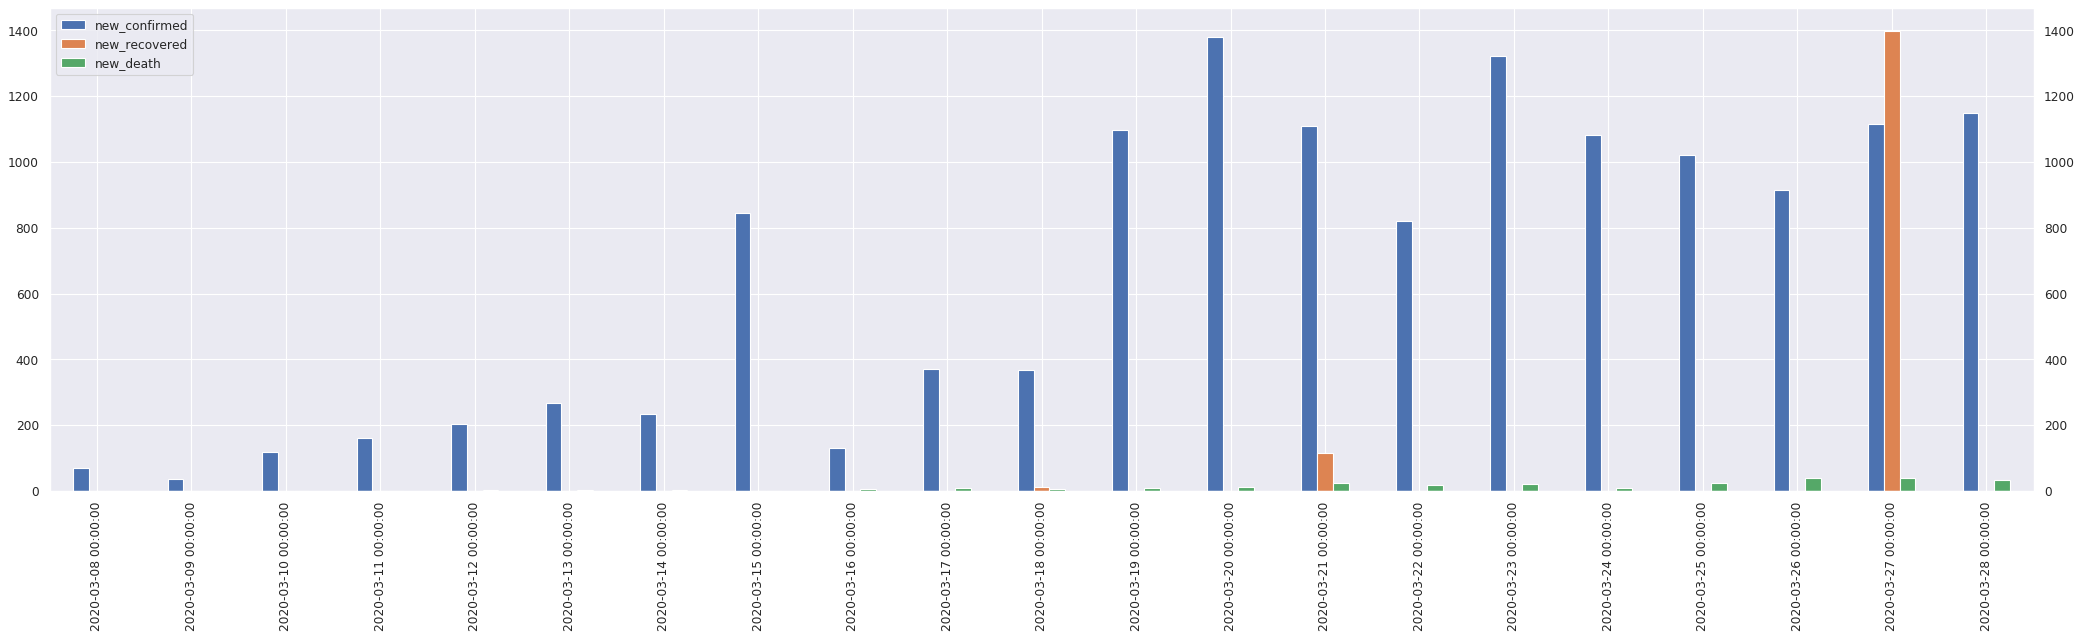

In [42]:
cbr_switzerland.plot_daily_stats()

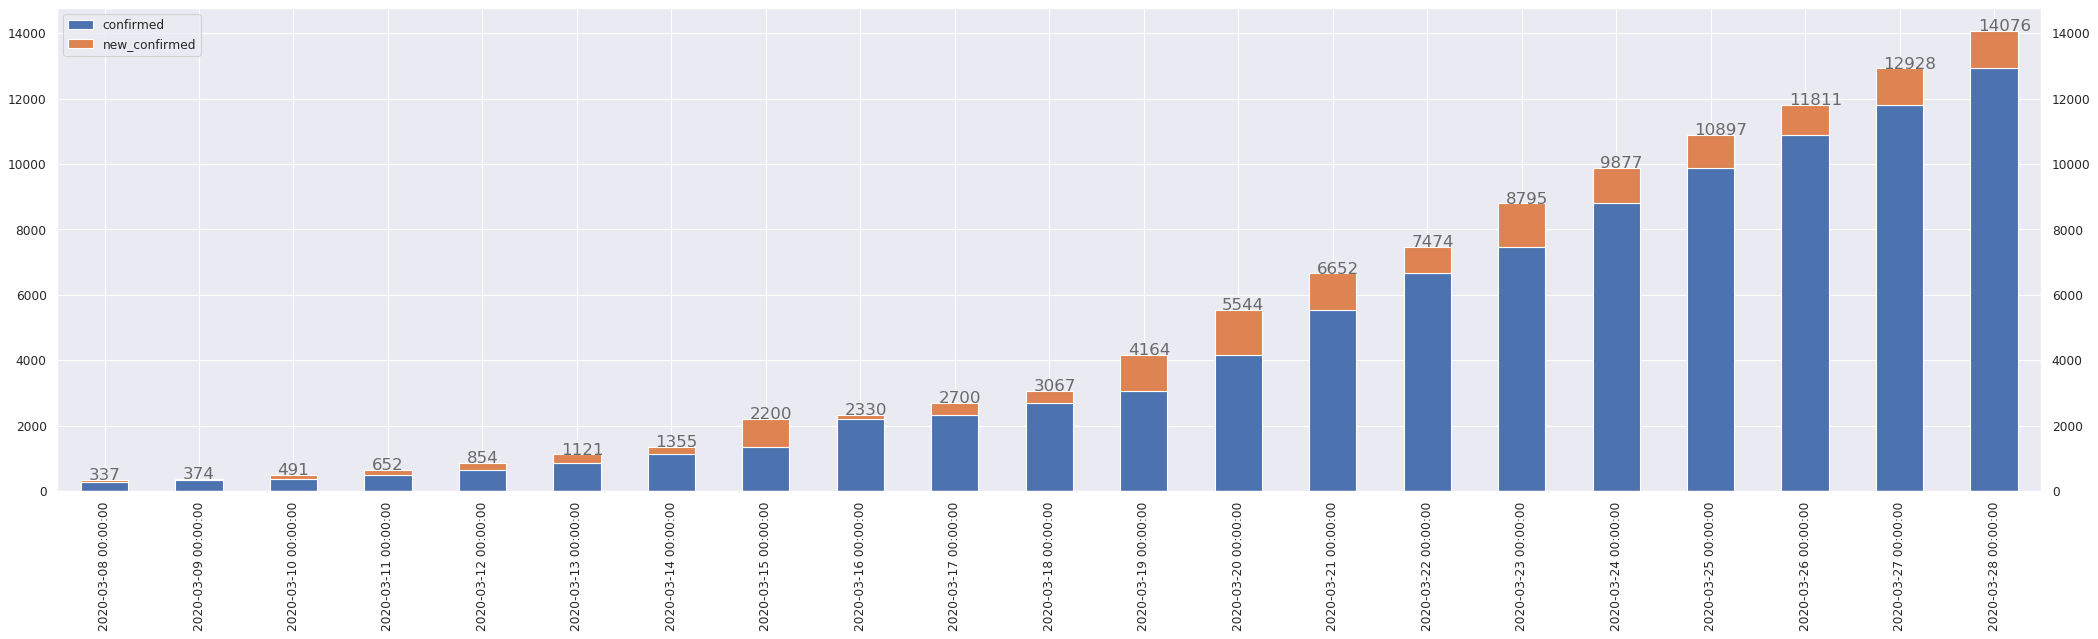

In [43]:
cbr_switzerland.plot_daily_stacked()

In [44]:
df_co = covid19.get_country_overview()
df_co.head()

,confirmed,recovered,death,death_rate,death_rate_
Country/Region_2020-03-28,,,,,
Gambia,3,0,1,33.333333,50.0
Nicaragua,4,0,1,25.000000,50.0
Cabo Verde,5,0,1,20.000000,50.0
Sudan,5,0,1,20.000000,50.0
Zimbabwe,7,0,1,14.285714,50.0


In [45]:
df_co[df_co.confirmed > 2000].round(1)

,confirmed,recovered,death,death_rate,death_rate_
Country/Region_2020-03-28,,,,,
Italy,92472,12384,10023,10.8,44.7
Spain,73235,12285,5982,8.2,32.7
Iran,35408,11679,2517,7.1,17.7
Netherlands,9819,6,640,6.5,98.9
France,38105,5724,2317,6.1,28.8
United Kingdom,17312,151,1021,5.9,87.0
China,81999,75100,3299,4.0,4.2
Belgium,9134,1063,353,3.9,24.9
Sweden,3447,16,105,3.0,86.1
